- 圳练数据是在MNIST数据集上，扩充了“。“+·、-、X、÷、(、)”·6种符号数据集，我们称之为“MNST+”数据集(存储在minist文件夹下)。每种样本以png图片格式保存在一个文件夹中(比如文件夹'0'、文件夹'('和文件夹'sub')，总共16个种类，每种含5000张以上图像样本。
- 总共100张测试样本图片，存储在test文件夹下。
- 1.基于mnist+数据集，训练一个深度神经网络（在LSTM、CAN+LSTM两个个网络结构中任选一个)，完成以下任务：
1)读取图片数据集；
2)创建深度神经网络模型；
3)训练模型：
4)测试模型；
5)输出测试精度。
2.以手写四则运算图片（白底黑字）为输入，完成：
1)使用连通域提取或者其它方法裁剪出图像中的每一个字符；
2)调整字符图片大小为28*28像素；
3)输入深度神经网络，识别图片中的所有字符，并输出识别结果；
4)输出图片中算式计算结果。
实例：
输入图片：
图片内容为3+15÷5
输出结果：
3+15/5
=64

In [4]:
import os
import cv2
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.nn.utils.rnn import pack_padded_sequence
from PIL import Image
from torch.utils.data import Dataset

#读取minist plus数据集
images = []#存放图片数据
targets = []#存放图片标签

dataset_path = './mnist+/'
labels = os.listdir(dataset_path)#读取文件夹下的文件名

for label in labels:
    folder_path = os.path.join(dataset_path, label)#文件夹路径
    for img_name in os.listdir(folder_path):#读取文件夹下的文件名
        img_path = os.path.join(folder_path, img_name).replace('\\','/')#图片路径
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)#读取灰度图
        images.append(img)
        targets.append(label)
        
#输出数据集大小
print('images size: ', len(images))
print('targets size: ', len(targets))

#将图片数据和标签转换为numpy数组

images=np.array(images) / 255.0#归一化
targets=np.array(targets)

#数据增强
#手段一:缩放
def scale_image(image,scale_factor):
    width=int(image.shape[1]*scale_factor)
    height=int(image.shape[0]*scale_factor)
    scale_image=cv2.resize(image,(width,height))
    return scale_image

#手段二:平移
def translate_image(image,shift_x,shift_y):
    tarnslate_matrix=np.float32([[1,0,shift_x],[0,1,shift_y]])
    shifted_image=cv2.warpAffine(image,tarnslate_matrix,(image.shape[1],image.shape[0]))
    return shifted_image

import random
def expand_dataset(images, targets):
    #扩充数据集
    new_images = []
    new_targets = []
    for i in range(len(images)):
        img = images[i]
        target = targets[i]
        for angle in [0, 90, 180, 270]:
            new_img = np.rot90(img, angle)
            new_images.append(new_img)
            new_targets.append(target)
    return np.copy(new_images, order='C'), np.copy(new_targets, order='C')

images, targets = expand_dataset(images, targets)
# 输出数据集大小
print('images size: ', len(images))
print('targets size: ', len(targets))

#数据处理
data_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((28,28)),
    transforms.ToTensor()
])
#自定义数据集
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.images[index]
        target = self.targets[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, target
    
    def __len__(self):
        return len(self.images)

dataset=MyDataset(images, targets, transform=data_transform)
images, targets = dataset.images, dataset.targets

#划分训练集和(测试集或者验证集)
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, random_state=42)
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=40, shuffle=True)#训练集
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=40, shuffle=True)#测试集


images size:  93903
targets size:  93903
images size:  375612
targets size:  375612


In [5]:
#创建LSTM模型
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()#继承父类
        self.hidden_size = hidden_size#隐藏层大小
        self.num_layers = num_layers#隐藏层数
        # self.dropout = nn.Dropout(0.5)#dropout层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)#LSTM层
        self.fc = nn.Linear(hidden_size, num_classes)#全连接层
        
    def forward(self, x):
        #初始化隐藏层和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        #前向传播LSTM层
        out, _ = self.lstm(x, (h0, c0))#out的形状为(batch_size, seq_length, hidden_size)
        
        #解码最后一个时刻的隐状态
        out = self.fc(out[:, -1, :])
        return out

In [17]:
#超参数设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')#如果有GPU则使用GPU
# model=LSTM(28, 128, 4, len(labels)).to(device)#创建模型
# criterion = nn.CrossEntropyLoss()#损失函数
# optimizer = optim.Adam(model.parameters(), lr=0.001)#优化器
model=LSTM(28, 128, 4, len(labels)).to(device)#创建模型
criterion = nn.CrossEntropyLoss()#损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)#优化器
num_epochs = 14#迭代次数

#训练模型
train_acc=[]#训练集准确率
train_loss=[]#训练集损失

for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        batch_images = batch_images.reshape(-1, 28, 28).to(device).float()#将图片转换为(batch_size, seq_length, input_size)
        batch_labels = torch.tensor([labels.index(label) for label in batch_labels]).to(device)#将标签转换为数字
        # 前向传播
        outputs = model(batch_images)
        # 计算损失
        loss = criterion(outputs, batch_labels)
        # 将梯度置零，反向传播，更新参数
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 计算训练的损失和准确率
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_acc += torch.sum(preds == batch_labels.data)
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)
    print('Epoch [{}/{}], Loss: {:.4f}, Acc: {:.4f}'.format(epoch+1, num_epochs, epoch_loss, epoch_acc))
    

Epoch [1/14], Loss: 0.3634, Acc: 34.9997
Epoch [2/14], Loss: 0.1193, Acc: 38.2663
Epoch [3/14], Loss: 0.0897, Acc: 38.6559
Epoch [4/14], Loss: 0.0759, Acc: 38.8457
Epoch [5/14], Loss: 0.0659, Acc: 38.9941
Epoch [6/14], Loss: 0.0591, Acc: 39.0906
Epoch [7/14], Loss: 0.0533, Acc: 39.1632
Epoch [8/14], Loss: 0.0495, Acc: 39.2299
Epoch [9/14], Loss: 0.0460, Acc: 39.2781
Epoch [10/14], Loss: 0.0441, Acc: 39.3119
Epoch [11/14], Loss: 0.0409, Acc: 39.3489
Epoch [12/14], Loss: 0.0388, Acc: 39.3949
Epoch [13/14], Loss: 0.0367, Acc: 39.4219
Epoch [14/14], Loss: 0.0347, Acc: 39.4524


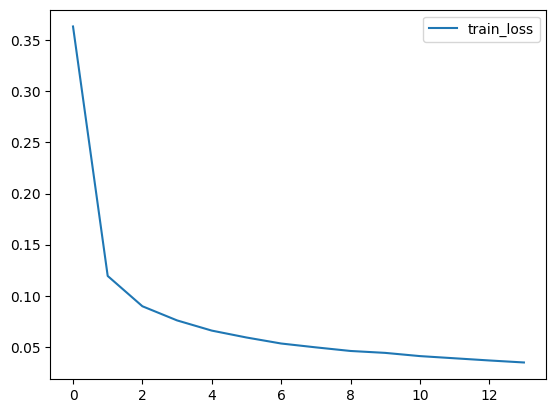

In [18]:
#绘制训练集准确率曲线
import matplotlib.pyplot as plt
#将tensor转换为numpy(因为tensor不能直接画图)
train_loss=torch.Tensor(train_loss).cpu().numpy()
plt.plot(train_loss, label='train_loss')
plt.legend()
plt.show()

In [19]:
#测试模型
correct = 0
total = 0
with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.reshape(-1, 28, 28).to(device).float()
        batch_labels = torch.tensor([labels.index(label) for label in batch_labels]).to(device)
        outputs = model(batch_images)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
print('Accuracy of the model on the test images: {}%'.format(100 * correct / total))
#保存模型
torch.save(model.state_dict(), './lstm.ckpt')
    

Accuracy of the model on the test images: 98.36534749677196%


In [8]:

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms


model.load_state_dict(torch.load('./lstm.ckpt'))
model.eval()
data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28,28)),
    transforms.ToTensor()
])

#预测函数
def predict(img):
    #输出图片维度
    # print(img.size)
    img = data_transform(img).reshape(-1, 28, 28).to(device).float()
    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
        predicted = labels[predicted.item()]
        return predicted

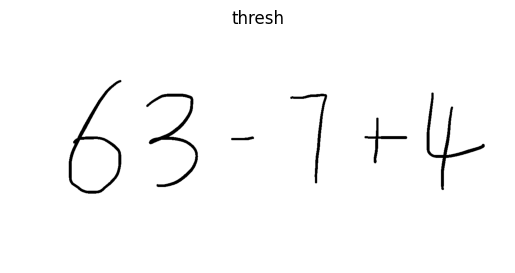

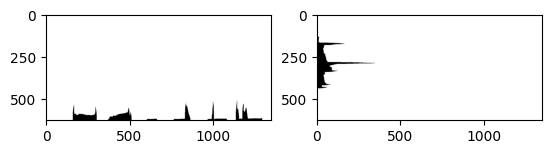

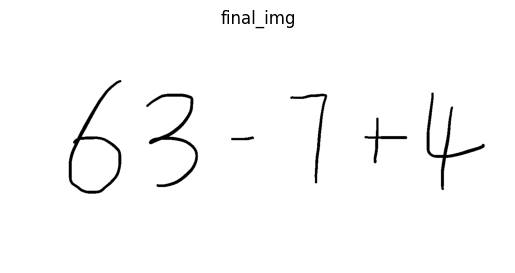

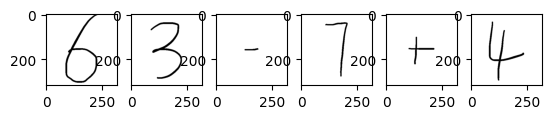

['6', '3', 'sub', '7', 'plus', '4']


In [14]:
import cv2

def show_img(img,title=None):
    """
        显示图像
        :param img:图像矩阵
        :return:无
    """
    if title is not None:
        plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()


def get_edge(test_img_path,img_name=None):
    """
        边缘提取
        :param img:图像矩阵
        :return:无
    """
    image=cv2.imread(test_img_path)
    #灰度化
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #二值化
    thresh=cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,333,1)
    show_img(thresh,'thresh')
    
    #对图像垂直水平投影
    (h,w)=thresh.shape
    #垂直投影
    vproject=thresh.copy()
    a=[0 for z in range(0,w)]
    for j in range(0,w):#遍历一列
        for i in range(0,h):#遍历一行
            if vproject[i,j]==0:#如果改点为黑点
                a[j]+=1#该列的计数器加1计数
                vproject[i,j]=255#记录完后将其变为白色
    for j in range(0,w):#遍历每一列
        for i in range((h-a[j]),h):#从该列应该变黑的最顶部的点开始向最底部涂黑
            vproject[i,j]=0 #涂黑
    #水平投影
    hproject=thresh.copy()
    b=[0 for z in range(0,h)]#创建数组并初始化为0
    for i in range(0,h):#遍历一行
        for j in range(0,w):#遍历一列
            if hproject[i,j]==0:#如果改点为黑点
                b[i]+=1#该行的计数器加1计数
                hproject[i,j]=255#记录完后将其变为白色
    for i in range(0,h):#遍历每一行
        for j in range(0,b[i]):#从该行应该变黑的最左边的点开始向最右边涂黑
            hproject[i,j]=0 #涂黑
      
    plt.subplot(1,2,1)
    plt.imshow(vproject,cmap='gray')#显示图像
    plt.subplot(1,2,2)
    plt.imshow(hproject,cmap='gray')#显示图像
    plt.show()

    #分割字符
    th=thresh.copy()
    final_img=thresh.copy()
    show_img(final_img,'final_img')
    h_h = b#水平投影
    start = 0#用来记录起始位置
    h_start,h_end = [],[]#记录起始和终止位置
    position = []#记录分割位置
    #根据水平投影获取垂直分割
    for i in range(len(h_h)):
        if h_h[i] >0 and start==0:
            h_start.append(i)
            start=1
        if h_h[i] ==0 and start==1:
            h_end.append(i)
            start = 0
    for i in range(len(h_start)):
        cropImg = th[h_start[i]:h_end[i],0:w]#裁剪坐标为[y0:y1, x0:x1]
        if i==0:
            pass
        w_w = a
        wstart,wend,w_start,w_end = 0,0,0,0
        for j in range(len(w_w)):
            if w_w[j]>0 and  wstart==0:
                w_start = j
                wstart = 1
                wend = 0
            if w_w[j] ==0 and wstart==1:
                w_end = j
                wstart = 0
                wend = 1
            #当确定了起点和终点之后保存坐标
            if wend ==1:
                position.append([w_start,h_start[i],w_end,h_end[i]])
                wend = 0
    #根据坐标切割字符
    character_images = []
    for p in position:
        character_img = final_img[p[1]:p[3],p[0]:p[2]]
        character_img = cv2.equalizeHist(character_img)#直方图均衡化,为了增强对比度
        #阈值
        ret,character_img = cv2.threshold(character_img,254,255,cv2.THRESH_BINARY)
        character_images.append(character_img)
        # show_img(character_img)
    # save_img(character_images,img_name)
    return character_images
    

def save_img(imgs,img_name):
    if os.path.exists('./processed/'+img_name):
        #清空文件夹
        shutil.rmtree('./processed/'+img_name)
    for i in range(len(imgs)):
        # imgs[i] = cv2.equalizeHist(imgs[i])
        os.makedirs('./processed/'+img_name,exist_ok=True)
        cv2.imwrite('./processed/'+img_name+'/'+str(i)+'.png',imgs[i])

def load_img(img_name, div_num):
    # img = Image.open(img_path)
    imgs=[]
    for i in range(div_num):
        pic_name = './processed/'+img_name+'/'+str(i)+'.png'
        # print(pic_name)
        img = Image.open(pic_name)
        # img = cv2.imread('./processed/'+img_name+'/'+str(i)+'.png')
        imgs.append(img)
    return imgs

def delete_img(img_name, div_num):
    for i in range(div_num):
        os.remove('./processed/'+img_name+'/'+str(i)+'.png')

def expand_img(character_images):
    expanded_imgs=[]
    width_max = 0
    hight_max = 0
    width_padding = 0
    hight_padding = 0
    offset=10
    for i,character_img in enumerate(character_images):
        width_max = character_img.shape[0]
        hight_max = character_img.shape[1]+10#加上偏移量因为这里图片高度固定，宽度不固定
        width_max = max(width_max,character_images[i].shape[1])+offset
        width_padding = width_max - character_images[i].shape[1]
        # hight_padding = hight_max - character_images[i].shape[0]
        expand_img = np.ones((width_max,width_max),dtype=np.uint8)*255
        #将原始图片放入扩展图片中心位置
        x_offset = width_padding//2
        y_offset = 0
        expand_img[y_offset:y_offset+character_images[i].shape[0],
                   x_offset:x_offset+character_images[i].shape[1]] = character_images[i]
        # expand_img[y_offset:y_offset+character_images[i].shape[0],x_offset:x_offset+character_images[i].shape[1]] = character_images[i]
        # character_images[i] = cv2.copyMakeBorder(character_images[i],0,0,0,padding,cv2.BORDER_CONSTANT,value=255)
        # show_img(character_images[i])
        # show_img(expand_img)
        expanded_imgs.append(expand_img)
    return expanded_imgs


model.load_state_dict(torch.load('./lstm.ckpt'))
model.eval()
#图片扩展
test_img_path = './test/86.png'#边缘线提取
character_images = get_edge(test_img_path)    
expand_imgs = expand_img(character_images)
for i in range(len(expand_imgs)):
    plt.subplot(1,len(expand_imgs),i+1)
    plt.imshow(expand_imgs[i],cmap='gray')
plt.show()

save_img(expand_imgs,'expand')
#加载图片
div_num = len(expand_imgs)
character_images = load_img('expand',div_num)

equation =[]
for img in character_images:
    predicted = predict(img)
    equation.append(predicted)
print(equation)

# character_images = load_img('edge',div_num)

In [103]:
def calculate(equation):
    OPERATORS = {'plus': '+', 'sub': '-', 'mul': '*', 'div': '/'}
    # Transform equation to infix notation
    infix = []
    for item in equation:
        if item in OPERATORS:
            infix.append(OPERATORS[item])
        elif item == 'left':
            infix.append('(')
        elif item == 'right':
            infix.append(')')
        else:
            infix.append(item)
    infix_equation = ''.join(infix)

    # Evaluate the expression
    result = eval(infix_equation)

    return result, infix_equation
# equation = ['1', 'mul', '2', 'add', 'left','4','sub', '2','right']
result, infix_equation = calculate(equation)
print('equation:', equation)
print(infix_equation, '=', result)

equation: ['6', '3', 'sub', '7', 'plus', '4']
63-7+4 = 60


In [ ]:
#输出pip环境
!pip freeze > requirements.txt